## LSTM测试

In [1]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import date
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd
import numpy as np
import requests
from requests.auth import HTTPBasicAuth

from datetime import datetime, timedelta
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

/Users/loki/PycharmProjects/PythonProject5/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# 获取人民币兑英镑汇率（Yahoo symbol: CNYGBP=X）
data = yf.download("CNYGBP=X", start="2015-01-01", end="2025-05-14")
er_df = data[["Close"]].rename(columns={"Close": "CNY/GBP"})
display(er_df.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,CNY/GBP
Ticker,CNYGBP=X
Date,
2015-01-01,0.10342
2015-01-02,0.10333
2015-01-05,0.10492
2015-01-06,0.10535
2015-01-07,0.10645


In [3]:
er_df['inverse'] = 1 / er_df['CNY/GBP', 'CNYGBP=X']

er_df

Price,CNY/GBP,inverse
Ticker,CNYGBP=X,
Date,,
2015-01-01,0.103420,9.669310
2015-01-02,0.103330,9.677731
2015-01-05,0.104920,9.531071
2015-01-06,0.105350,9.492169
2015-01-07,0.106450,9.394082
...,...,...
2025-05-07,0.103741,9.639391
2025-05-08,0.104124,9.603934


In [4]:
policy_df = pd.read_excel("IR.xlsx")
policy_df['rate_diff'] = policy_df['UK'] - policy_df['CN']
model_df = policy_df.copy()

In [5]:
# 确保 Date 是 datetime 类型
model_df['Date'] = pd.to_datetime(model_df['Date'])

# 保留工作日（周一到周五）
df_weekday = model_df[model_df['Date'].dt.dayofweek < 5].copy()

# 按日期排序（可选）
df_weekday = df_weekday.sort_values('Date').reset_index(drop=True)

In [6]:
missing_dates = df_weekday[~df_weekday['Date'].isin(er_df.index)]
print(missing_dates['Date'].tail(10))

658    2017-07-11
750    2017-11-16
2609   2025-01-01
2686   2025-04-18
2687   2025-04-21
Name: Date, dtype: datetime64[ns]


In [7]:
# 确保 Date 列格式一致
df_weekday['Date'] = pd.to_datetime(df_weekday['Date']).dt.normalize()

# 筛选 df_weekday 中仅保留那些出现在 er_df['Date'] 中的行
df_weekday_aligned = df_weekday[df_weekday['Date'].isin(er_df.index)].copy()

In [8]:
er_mid = er_df['inverse'].reset_index(drop=True)

In [9]:
df_weekday_aligned['ER'] = er_mid
df_weekday_aligned.drop(['UK','CN'], axis=1, inplace=True)
df_weekday_aligned

,Date,rate_diff,ER
0,2015-01-01,-5.10,9.669310
1,2015-01-02,-5.10,9.677731
2,2015-01-05,-5.10,9.531071
3,2015-01-06,-5.10,9.492169
4,2015-01-07,-5.10,9.394082
...,...,...,...
2699,2025-05-07,1.15,NaN
2700,2025-05-08,1.15,NaN
2701,2025-05-09,1.15,NaN
2702,2025-05-12,1.15,NaN


In [10]:
df_weekday_aligned['trade_war'] = 0
df_weekday_aligned.loc[(df_weekday_aligned['Date'] >= '2018-03-22') & (df_weekday_aligned['Date'] <= '2018-12-01'), 'trade_war'] = 1
df_weekday_aligned.loc[(df_weekday_aligned['Date'] >= '2025-02-01') & (df_weekday_aligned['Date'] <= '2025-05-12'), 'trade_war'] = 1

In [11]:
lstm_df = df_weekday_aligned.dropna()

lstm_df['Date'] = pd.to_datetime(lstm_df['Date'])  # 保证为 datetime 类型
lstm_df = lstm_df.set_index('Date')  # 设置为 index

/var/folders/nb/lml3l_ls6b7gzy20lpv559vh0000gn/T/ipykernel_39216/3524985256.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_df['Date'] = pd.to_datetime(lstm_df['Date'])  # 保证为 datetime 类型


In [12]:
# Split data into training and testing sets (e.g., train: 2010-01 to 2022-12, test: 2023-01 to 2024-12)
split_date = pd.Timestamp('2023-01-01')  # end of Jan 2023 marks beginning of test period
train_df = lstm_df[:split_date]   # up to Dec 2022
test_df = lstm_df[split_date:]    # 2023-01 through 2024-12

# Separate features (X) and target (y)
X_train = train_df
y_train = train_df['ER']
X_test = test_df
y_test = test_df['ER']

# Normalize features and target using Min-Max scaling (fit on training data only)
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

# Prepare data for LSTM: create sequences of length `lookback` for each training example
lookback = 12  # use past 12 months to predict the next month
X_train_seq, y_train_seq = [], []
for i in range(lookback, len(X_train_scaled)):
    # sequence of `lookback` feature vectors
    X_train_seq.append(X_train_scaled[i-lookback:i])
    # target is the exchange rate at this time (one month ahead of last input month)
    y_train_seq.append(y_train_scaled[i])
X_train_seq = np.array(X_train_seq)
y_train_seq = np.array(y_train_seq)

# Prepare sequences for the test set (using preceding data for initial sequence)
X_test_seq, y_test_seq = [], []
# Concatenate train and test for sequence generation to include trailing train data in initial test sequences
total_X = np.concatenate((X_train_scaled, X_test_scaled), axis=0)
total_y = np.concatenate((y_train_scaled, y_test_scaled), axis=0)
train_len = len(X_train_scaled)
for i in range(train_len, len(total_X)):
    if i < lookback:
        continue  # skip until we have enough history
    X_test_seq.append(total_X[i-lookback:i])
    y_test_seq.append(total_y[i])
X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq)

# Build the LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
# 改进后的双层 LSTM 架构
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(lookback, X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1))

# 别忘了这一步！！
model.compile(optimizer='adam', loss='mean_squared_error')

# 然后再训练
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/50


/Users/loki/PycharmProjects/PythonProject5/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0404 - val_loss: 0.0056
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 10/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 11/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 12/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

Test MSE Loss: 0.002303
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


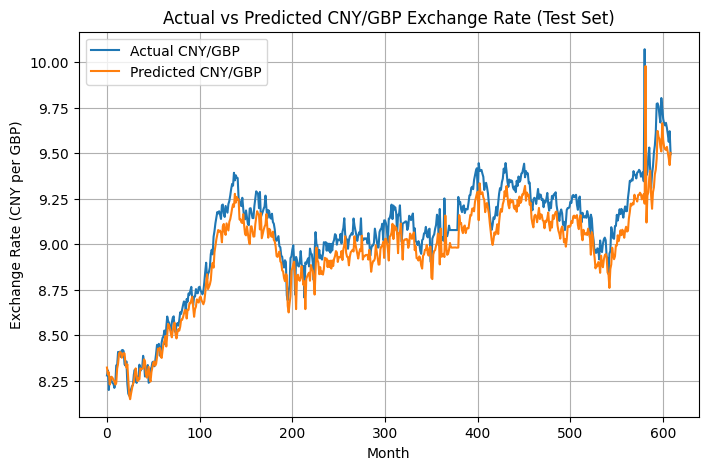

In [13]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Test MSE Loss: {test_loss:.6f}")

# Make predictions for the test period
y_pred_scaled = model.predict(X_test_seq)
# Inverse-transform the predictions back to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_actual = target_scaler.inverse_transform(y_test_seq)

# Visualize the results: Actual vs Predicted exchange rate

plt.figure(figsize=(8,5))
plt.plot(y_actual, label='Actual CNY/GBP')
plt.plot(y_pred, label='Predicted CNY/GBP')
plt.title('Actual vs Predicted CNY/GBP Exchange Rate (Test Set)')
plt.xlabel('Month')
plt.ylabel('Exchange Rate (CNY per GBP)')
plt.legend()
plt.grid(True)
plt.show()